## Chapter 9
# Virtual Musical Instruments
## Clarinet

In [1]:
import numpy as np

import sys
sys.path.append('../')

from Filters import OneZeroFilter
from Generators import NoiseGenerator, SineGenerator
sys.path.append('../musimathics')
from pitches import frequency_for_note_label, frequencies_for_note_labels
note2freq = frequency_for_note_label
notes2freqs = frequencies_for_note_labels

import matplotlib.pyplot as plt
%matplotlib inline

from DelayLine import DelayLine
from SamplePlayer import SamplePlayer, WavPlayer
from AllpassDelay import AllpassDelay

sample_rate = fs = 44100
lowest_frequency = note2freq('A0')
highest_frequency = note2freq('C8')

In [2]:
# This class implements a simple one breakpoint,
# non-linear reed function, as described by
# Smith (1986).  This function is based on a
# memoryless non-linear spring model of the reed
# (the reed mass is ignored) which saturates when
# the reed collides with the mouthpiece facing.

# See McIntyre, Schumacher, & Woodhouse (1983),
# Smith (1986), Hirschman, Cook, Scavone, and
# others for more information.
class ReedTable:
    def __init__(self):
        self.offset = 0.6
        self.slope = -0.8

    def tick(self, in_sample):
        # The input is differential pressure across the reed.
        out_sample = self.offset + self.slope * in_sample

        # If output is > 1, the reed has slammed shut and the
        # reflection function value saturates at 1.0.
        out_sample = min(out_sample, 1.0)

        # This is nearly impossible in a physical system, but
        # a reflection function value of -1.0 corresponds to
        # an open end (and no discontinuity in bore profile).
        out_sample = max(-1.0, out_sample)

        return out_sample

    def key_on(self):
        self.set_target(1.0)

    def key_off(self):
        self.set_target(0.0)

    def set_offset(self, offset):
        self.offset = offset
        
    def set_slope(self, slope):
        self.slope = slope

class EnvelopeGenerator:
    def __init__(self):
        self.target = 0.0
        self.value = 0.0
        self.rate = 0.001
        self.state = False

    def tick(self):
        if self.state:
            if self.target > self.value:
                self.value += self.rate
                if self.value >= self.target:
                    self.value = self.target
                    self.state = 0
            else:
                self.value -= self.rate
                if self.value <= self.target:
                    self.value = self.target
                    self.state = False
        return self.value

    def set_rate(self, rate):
        self.rate = rate
    
    def set_target(self, target):
        self.target = target
        if self.value != self.target:
            self.state = True

# envelope + noise + vibrato
class BreathPressureGenerator:
    def __init__(self):
        self.envelope = EnvelopeGenerator()
        self.noise = NoiseGenerator(gain=0.2)
        self.vibrato = SineGenerator()
        self.vibrato.set_frequency(5.735)
        self.vibrato.amplitude = 0.05
        
        self.last_envelope_out = 0.0
        self.last_noise_out = 0.0
        self.last_vibrato_out = 0.0

    def tick(self):
        self.last_noise_out = self.noise.tick()
        self.last_vibrato_out = self.vibrato.tick()

        self.last_envelope_out = self.envelope.tick()
        breath_pressure = self.last_envelope_out
        breath_pressure += breath_pressure * self.last_noise_out
        breath_pressure += breath_pressure * self.last_vibrato_out

        return breath_pressure

    # Apply breath pressure to instrument with given amplitude and rate of increase.
    def start_blowing(self, amplitude, rate):
        assert(amplitude > 0 and rate > 0)

        self.envelope.set_rate(rate)
        self.envelope.set_target(amplitude)

    # Decrease breath pressure with given rate of decrease.
    def stop_blowing(self, rate):
        self.envelope.set_rate(rate)
        self.envelope.set_target(0.0)

    def set_vibrato_frequency(self, vibrato_frequency):
        self.vibrato.set_frequency(vibrato_frequency)

    def set_vibrato_gain(self, vibrato_gain):
        self.vibrato.amplitude = vibrato_gain
    
    def set_noise_gain(self, noise_gain):
        self.noise.gain = noise_gain

    
class Clarinet:
    def __init__(self):
        self.filter = OneZeroFilter()
        self.breath_pressure_gen = BreathPressureGenerator()
        self.output_gain = 1.0

        max_delay_samples = 0.5 * fs / lowest_frequency
        self.delay_line = AllpassDelay(max_delay_samples, int(max_delay_samples) + 1)

        self.reed_table = ReedTable()
        self.set_reed_stiffness(0.5)

        self.set_frequency(note2freq('A3'))
        self.clear()

    def tick(self):
        self.last_breath_pressure_out = self.breath_pressure_gen.tick()
        # Perform commuted loss filtering.
        self.last_pressure_diff = -0.95 * self.filter.tick(self.delay_line.last_out)
        # Calculate pressure difference of reflected and mouthpiece pressures.
        self.last_pressure_diff -= self.last_breath_pressure_out
        self.last_reed_table_out = self.reed_table.tick(self.last_pressure_diff)
        # Perform non-linear scattering using pressure difference in reed function.
        return self.output_gain * self.delay_line.tick(self.last_breath_pressure_out +
                                                       self.last_pressure_diff*self.last_reed_table_out)

    def note_on(self, frequency, amplitude):
        self.set_frequency(frequency)
        self.breath_pressure_gen.start_blowing(0.55 + (amplitude * 0.3), amplitude * 0.001)
        self.output_gain = amplitude + 0.001

    def note_off(self, amplitude):
        self.breath_pressure_gen.stop_blowing(amplitude * 0.01)

    def set_frequency(self, frequency):
        # Account for filter delay and one sample "last out" delay.
        delay = 0.5 * (fs / frequency) - 1.0#self.filter.phase_delay(frequency) - 1.0
        self.delay_line.set_delay_samples(delay)

    # Realtime controls
    def set_reed_stiffness(self, reed_stiffness):
        self.reed_table.set_slope(-0.44 + (0.26 * reed_stiffness))
    def set_noise_gain(self, noise_gain):
        self.breath_pressure_gen.set_noise_gain(noise_gain)
    def set_vibrato_frequency(self, vibrato_frequency):
        self.breath_pressure_gen.set_vibrato_frequency(vibrato_frequency)
    def set_vibrato_gain(self, vibrato_gain):
        self.breath_pressure_gen.set_vibrato_gain(vibrato_gain)

    def clear(self):
        self.delay_line.clear()
        self.filter.clear()

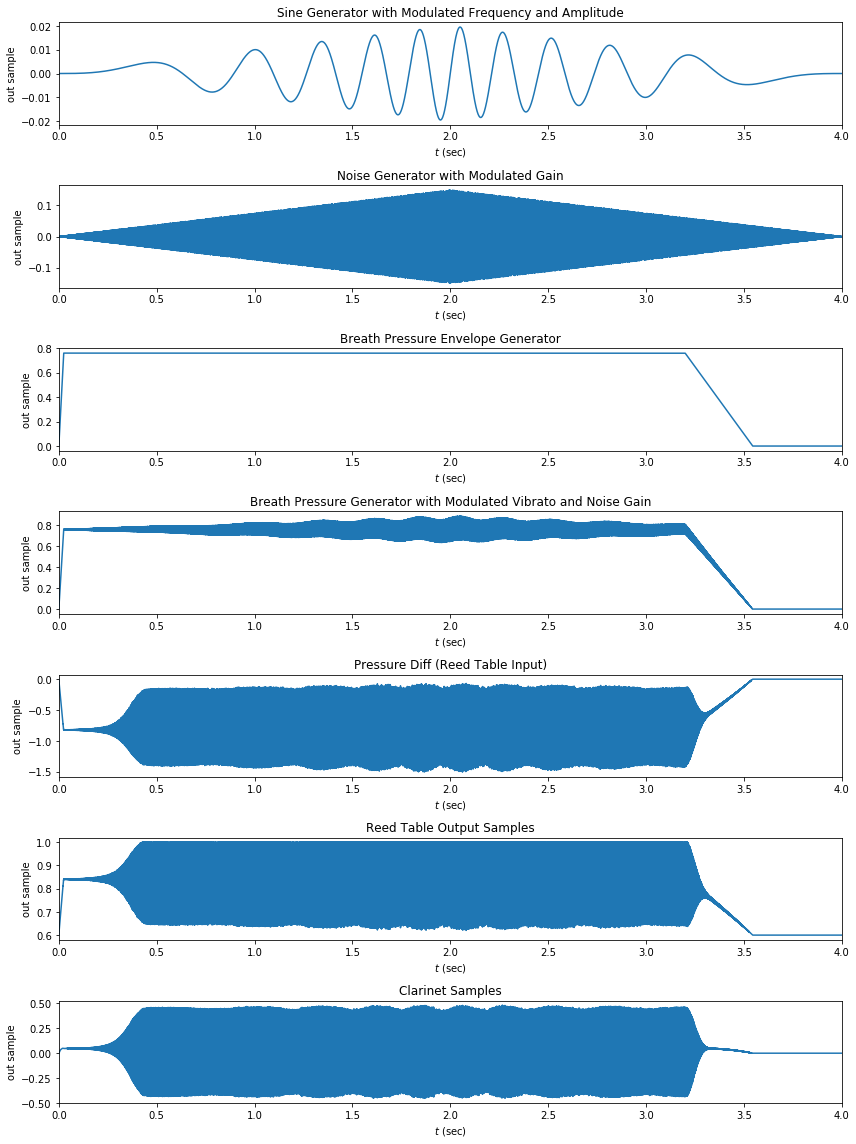

In [3]:
fig, plots = plt.subplots(7, 1, figsize=(12, 16))
[sine_plot, noise_plot, envelope_plot, breath_plot, pressure_diff_plot, reed_table_plot, clarinet_plot] = plots

clarinet = Clarinet()
clarinet.set_reed_stiffness(0.57)

t = np.arange(4 * fs) / fs
triangle = np.concatenate([np.linspace(0, 1, t.size // 2),
                           np.linspace(1, 0, t.size // 2)])
noise_gain_ramp = triangle * 0.15
vibrato_frequency_ramp = triangle * 5
vibrato_gain_ramp = triangle * 0.02

sine_y = np.zeros(t.size)
noise_y = np.zeros(t.size)
envelope_y = np.zeros(t.size)
breath_y = np.zeros(t.size)
pressure_diff_y = np.zeros(t.size)
reed_table_out_samples = np.zeros(t.size)
clarinet_out_samples = np.zeros(t.size)

breath_duration_samples = int(4*t.size//5) # hold for 4/5 of the duration
clarinet.note_on(note2freq('F4'), 0.7)

for i in range(t.size):
    if i == breath_duration_samples:
        clarinet.note_off(0.005)

    clarinet.set_vibrato_frequency(vibrato_frequency_ramp[i])
    clarinet.set_vibrato_gain(vibrato_gain_ramp[i])
    clarinet.set_noise_gain(noise_gain_ramp[i])

    clarinet_out_samples[i] = clarinet.tick()

    sine_y[i] = clarinet.breath_pressure_gen.last_vibrato_out
    noise_y[i] = clarinet.breath_pressure_gen.last_noise_out
    envelope_y[i] = clarinet.breath_pressure_gen.last_envelope_out
    breath_y[i] = clarinet.last_breath_pressure_out
    pressure_diff_y[i] = clarinet.last_pressure_diff
    reed_table_out_samples[i] = clarinet.last_reed_table_out

sine_plot.plot(t, sine_y)
sine_plot.set_title('Sine Generator with Modulated Frequency and Amplitude')

noise_plot.plot(t, noise_y)
noise_plot.set_title('Noise Generator with Modulated Gain')

envelope_plot.plot(t, envelope_y)
envelope_plot.set_title('Breath Pressure Envelope Generator')

breath_plot.plot(t, breath_y)
breath_plot.set_title('Breath Pressure Generator with Modulated Vibrato and Noise Gain')

pressure_diff_plot.plot(t, pressure_diff_y)
pressure_diff_plot.set_title('Pressure Diff (Reed Table Input)')

reed_table_plot.plot(t, reed_table_out_samples)
reed_table_plot.set_title('Reed Table Output Samples')

clarinet_plot.plot(t, clarinet_out_samples)
clarinet_plot.set_title('Clarinet Samples')

for plot in plots:
    plot.set_xlim(0, t.size / fs)
    plot.set_xlabel('$t$ (sec)')
    plot.set_ylabel('out sample')

plt.tight_layout()

In [4]:
from IPython.display import Audio

Audio(clarinet_out_samples, rate=fs)

In [5]:
from scipy.io.wavfile import write as write_wav
write_wav('clarinet_mod_vibrato_and_noise.wav', rate=fs, data=clarinet_out_samples)

Let's explore some parameter modulation curves!

In [41]:
def play_note_with_parameter_curves(frequency, on_amplitude, off_amplitude,
                                    reed_stiffness_curve,
                                    vibrato_frequency_curve, vibrato_gain_curve, noise_gain_curve):
    n = len(vibrato_frequency_curve)
    clarinet = Clarinet()
    clarinet.note_on(frequency, on_amplitude)
    clarinet_out_samples = np.zeros(n)
    for i in range(n):
        if i == n - fs: # stop note a second before the end
            clarinet.note_off(off_amplitude)
        clarinet.set_reed_stiffness(reed_stiffness_curve[i])
        clarinet.set_vibrato_frequency(vibrato_frequency_curve[i])
        clarinet.set_vibrato_gain(vibrato_gain_curve[i])
        clarinet.set_noise_gain(noise_gain_curve[i])
        clarinet_out_samples[i] = clarinet.tick()

    return Audio(clarinet_out_samples, rate=fs)

In [43]:
num_samples = fs * 5
play_note_with_parameter_curves(note2freq('A4'), 0.9, 0.01,
                                np.linspace(0.5, 0.5, num_samples),
                                np.linspace(0, 5, num_samples),
                                np.linspace(0, 0.2, num_samples),
                                np.linspace(0.8, 0.3, num_samples))                                

In [44]:
num_samples = fs * 6
play_note_with_parameter_curves(note2freq('A4'), 0.5, 0.01,
                                np.linspace(0.4, 0.4, num_samples),
                                np.linspace(0, 0.3, num_samples),
                                np.linspace(0, 0.15, num_samples),
                                np.linspace(0.1, 1.0, num_samples))

In [45]:
num_samples = fs * 6
play_note_with_parameter_curves(note2freq('D2'), 0.1, 0.01,
                                np.linspace(0.1, 0.9, num_samples),
                                np.linspace(0, 0.3, num_samples),
                                np.linspace(0, 0.15, num_samples),
                                np.linspace(0.1, 0.2, num_samples))

In [64]:
num_samples = fs * 6
play_note_with_parameter_curves(note2freq('A#4'), 0.9, 0.01,
                                np.linspace(0.5, 0.2, num_samples),
                                np.linspace(1, 6, num_samples),
                                np.linspace(0.1, 0.15, num_samples),
                                np.linspace(0.2, 0.4, num_samples))

In [70]:
clarinet = Clarinet()
clarinet.set_reed_stiffness(0.4)
clarinet.set_noise_gain(0.3)
clarinet.set_vibrato_gain(0.03)

clarinet_out_samples = np.zeros(fs * 6)

note_frequencies = notes2freqs(['C3', 'D3', 'E3', 'F3', 'G3', 'A3', 'B3', 'C4'])
note_on_samples = np.arange(len(note_frequencies)) * fs // 2
note_off_samples = note_on_samples + 4 * fs // 10
note_off_samples[-1] = clarinet_out_samples.size - fs # hold last note til a second before the end
note_index = 0
for i in range(clarinet_out_samples.size):
    if np.isin(i, note_on_samples):
        amplitude = np.random.uniform(low=0.5, high=1.0)
        clarinet.note_on(note_frequencies[note_index], amplitude)
        note_index += 1
    elif np.isin(i, note_off_samples):
        clarinet.note_off(0.008)
    clarinet_out_samples[i] = clarinet.tick()

Audio(clarinet_out_samples, rate=fs)

In [71]:
write_wav('clarinet_c_scale_rand_amp.wav', rate=fs, data=clarinet_out_samples)

A "stiffer reed" and more "breath" makes it sound a little more like a recorder or flute:

In [80]:
clarinet = Clarinet()
clarinet.set_reed_stiffness(0.65)
clarinet.set_noise_gain(0.5)
clarinet.set_vibrato_gain(0.025)

note_frequencies = notes2freqs(['C4', 'D4', 'E4', 'F4', 'G4', 'A4', 'B4', 'C5'])
note_index = 0
for i in range(clarinet_out_samples.size):
    if np.isin(i, note_on_samples):
        amplitude = np.random.uniform(low=0.7, high=1.0)
        clarinet.note_on(note_frequencies[note_index], amplitude)
        note_index += 1
    elif np.isin(i, note_off_samples):
        clarinet.note_off(0.008)
    clarinet_out_samples[i] = clarinet.tick()

Audio(clarinet_out_samples, rate=fs)

Here is an example of a much more elaborate and realistic clarinet model: [github link](https://github.com/Eigenlabs/EigenD/blob/f5614c98d12c85c4db5f0026797b881eb94b220e/plg_stk/src/Clarinet2.cpp)

It's based [this Csound Clarinet implementation](http://www.csounds.com/jmc/Articles/Woodwinds/Csound%20Woodwinds.htm) by Josep M Comajuncosas.


## Where to go from here?

This series of books is, far and away and without a doubt, the most valuable resource on the topic of physical modelling, and I would argue audio DSP in general. It is an understatement that the work of Julius Smith over the course of his career has advanced the field dramatically. I hope that more researchers in these areas publish works half as generous as these. I also hope more hobbyists and enthusiasts (or some of JOS's students at Stanford! ☺) step out further than I have, sharing implementations, guides and animations to the community.

The next (or, as the author suggests, _parallel_) book in the series is [Specral Audio Signal Processing](https://ccrma.stanford.edu/~jos/sasp/). I plan on getting to that book and creating a chapter-by-chapter notebook series like I have for the rest of the books. It looks _much_ less esoteric, and focuses on more well-established domains such as the short-time-fourier-transform. I'm looking forward to getting to it as I'm very interested in time & pitch warping, and in general more abstract, non-physical audio manipulation methods. However, as I don't have as much free time these days, I'm feeling the itch to step away from the academic side for awhile and get back to "real" audio software projects. So it'll likely be awhile before that happens.

For what it's worth, here is a random smattering of resources and interesting links I've found in the physical audio modelling space:
* [The STK](https://github.com/thestk/stk) - used as the main playground for the assigned labs in this book. Implements a bunch of physical models using a variety of techniques that are covered here and in the text.
* [Faust](https://faust.grame.fr/) is a functional programming language for audio processing.
* The [Faust Physical Modeling Toolkit](https://ccrma.stanford.edu/~rmichon/pmFaust/) is "a collection tools to facilitate the design of physical models with the Faust programming language"
* [RT-WDF](https://github.com/RT-WDF/rt-wdf_lib), a "real-time capable Wave Digital Filter library for circuit modeling, with support for arbitrary topologies and multiple/multiport non-linearities".
* [Next Generation Sound Synthesis](https://www.ness.music.ed.ac.uk/project) - a research group implementing a highly realistic set of physical models, mostly using finite difference methods over a high-precision grid, designed to be executed on highly parallel GPUs.